<font size = "5"> **[Diffraction Tools](1_Diffraction_Tools.ipynb)** </font>

<hr style="height:2px;border-top:4px solid #FF8200" />


# Ronchigram


[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Diffraction/D3_Ronchigram.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Diffraction/D3_Ronchigram.ipynb)

    

part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package


Notebook by Gerd Duscher, 2025

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes


## Content

An introduction into Rochigram and simulate them with 
- **diffraction_tools** and 
= **probe_tools**.

The scope of this notebook includes calculation and plotting of 
- Aberration Function $\chi$,
- Ronchigram 
- Phaseplate.

for conventional and aberration corrected TEMs.

An explanation on the physcial background can be found in the *Imaging* chapter of MSE672-Introduction to TEM


## Install pyTEMlib

If you have not done so in the [Introduction Notebook](../0_pyTEMlib.ipynb), please test and install [pyTEMlib](https://github.com/pycroscopy/pyTEMlib) and other important packages with the code cell below.



## Load relevant python packages
### Check Installed Packages

In [ ]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test whether package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2025.12.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q --upgrade

print('done')

### Load the plotting and figure packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,
* three dimensional plotting
and some libraries from the book
* kinematic scattering library from diffraction_tools in pyTEMlib.

In [3]:
%matplotlib  widget
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

if 'google.colab' in sys.modules:
    from google.colab import output
    from google.colab import drive
    output.enable_custom_widget_manager()

# Import microscopt library
sys.path.insert(0, "../../")  # point to the pyTEMlib location
%load_ext autoreload
%autoreload 2
import pyTEMlib
    
# it is a good idea to show the version numbers at this point for archiving reasons.
__notebook_version__ = '2025.12.06'
print('pyTEM version: ', pyTEMlib.__version__)
print('notebook version: ', __notebook_version__)

pyTEM version:  0.2025.12.1
notebook version:  2025.12.06


## Goal
We want to illuminate an aperture with an as coherent (homogeneous) wave as possible. In the ideal all points have the same amplitude and phase which we associate with 1.0 inside the aperture and zero outside.

### Diffraction Limit
The restriction of resolution with convergence angle is called **diffraciton limit**

This is the ideal case of a probe forming aperture without any aberrations.

Change the convergence angle and see wha happens

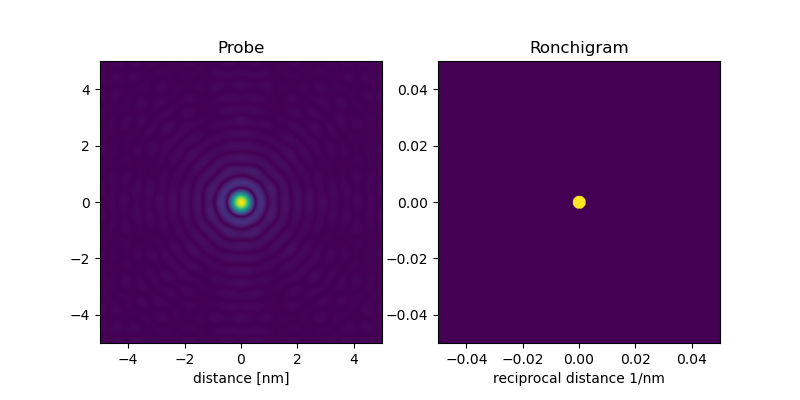

In [4]:
# ---Input  ----
convergence_angle = 30 # in mrad
FOV = 10 # in 1/nm
acceleration_voltage = 200000  # in V
# ---------------

ApAngle=convergence_angle/1000.0 # in rad

wl = pyTEMlib.utilities.get_wavelength(acceleration_voltage, unit='A')
sizeX = sizeY = 512

## Reciprocal plane in 1/nm
dk = 1/FOV
kx = np.array(dk*(-sizeX/2.+ np.arange(sizeX)))
ky = np.array(dk*(-sizeY/2.+ np.arange(sizeY)))
Txv, Tyv = np.meshgrid(kx, ky)

# define reciprocal plane in angles
phi =  np.arctan2(Txv, Tyv)
theta = np.arctan2(np.sqrt(Txv**2 + Tyv**2),1/wl)

## Aperture function 
mask = theta >= ApAngle

aperture =np.ones((sizeX,sizeY),dtype=float)
aperture[mask] = 0.
    
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow((np.abs(np.fft.fftshift(np.fft.ifft2(aperture)))), extent = [-int(FOV/2),int(FOV/2),-int(FOV/2),int(FOV/2)])
ax[0].set_xlabel('distance [nm]')
ax[0].set_title('Probe')
ax[1].imshow(aperture, extent = [-(1/FOV/2),(1/FOV/2),-(1/FOV/2),(1/FOV/2)])
ax[1].set_xlabel('reciprocal distance 1/nm')
ax[1].set_title('Ronchigram');


### Source Size
The probe is in a way the demagnified image of the electron source and this demagnification is controlled by condesor lenses.


## Ronchigram Introduction

A ronchigram is generally a convergent beam electron diffraction pattern (CBED) in which the electron beam is NOT focused on the sample.  This experimental setup gives a so called **shadow image**. While not strictly within definition some authors refer to ronchigrams and inplicitly mean of an amorphous specimen.

John M.  Cowley https://doi.org/10.1016/S0304-3991(79)80018-2; https://doi.org/10.1016/S0304-3991(79)80021-2 laid the basis for the usage of Ronchigram in alignment of transmission electron microscopes in **scanning** and **convergent** beam mode.


The goal of the alignment is to illuminate the probe forming aperture (mostly the condensor aperture) with a coherent patch.

The Ronchigram is also used to determine the aberration function which in turn is used to correct for lens aberrations.

The following discussion of Ronchigrams depends on the following  assamptions:
 - The specimen is expressed as a 2 dimensional potential, which neglects the dependence of the electron-specimen interaction on different incident angles and all dynamical effects. 

- Fresnel diffraction is neglected which causes contrast reversal of particles and at voids.  Diffraction is assumed to be  purely in the Fraunhofer regime. 

- Bragg diffraction and the associated interference of diffracted beams is omitted.

Therefore the following discussion is reduced to Ronchigrams of thin amorphous samples of a light element. This is incidentally the sample of choice for alignemnt in STEM mode. 

### Aberration Function $\chi$

Please see this notebook for a more detailed discussion of the [Aberration Function](CH3_03-CTF.ipynb#Aberrations)

With the main aberration coefficients $C_{n,m}$:

Coefficient  Nion | CEOS | Name
 ----------------|------------- | -------------
 $C_{10}$ | $C_1$ |defocus
 $C_{12a}$, $C_{12b}$  | $A_1$ |astigmatism
 $C_{21a}$, $C_{21b}$  | $B_2$ |coma
 $C_{23a}$, $C_{23b}$  | $A_2$ |three-fold astigmatism
 $C_{30}$  | $C_3$ |spherical aberration
    
As before the aberration function $\chi$ in polar coordinates (of angles) $\theta$ and $\phi$ is defined according to [Krivanek et al.](https://doi.org/10.1016/S0304-3991(99)00013-3):

$$
\chi(\theta, \phi) = \sum_n \theta^{n+1} *\frac{1}{n+1} * \sum_{n} C_{n,m,a}  \cos(m*\phi) + C_{n,m,b} \sin(m*\phi) 
$$

with:
- $n$: order ($n=0,1,2,3,...$)
- $m$: symmetry  $m = ..., n+1$;  
    - $m$ is all odd   for n = even
    - $m$ is all even  for n = odd

    

In the following we program the equation above just as seen. The terms are divided into the theta (line 22) and the sum part (line 33).  The product of these two terms is summed in line 39.

We assume that the aberrations are given up to fifth order.




## Calculate Ronchigram

The aberration coefficients to calculate a conventional TEM are used as an example below.


0.57


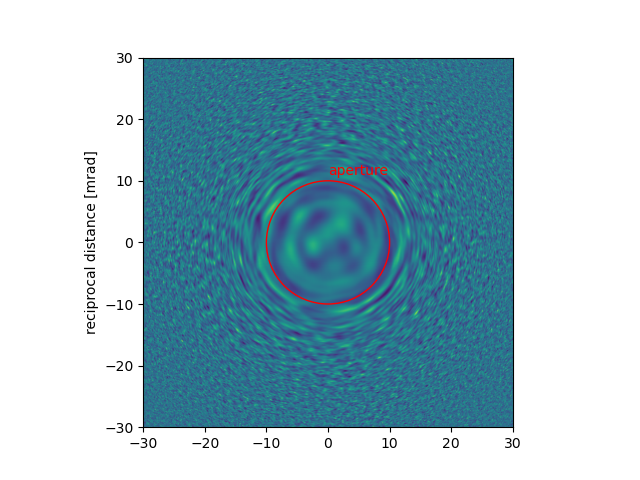

In [7]:
# --- Input --------------
aperture_radius = 10 # in mrad
aberrations = {'C10':  -190, # aberrations in nm
               'C12a': 2.42161,
               'C12b': 0.963,
               'C21a': -114.478,
               'C21b': -30.4613,
               'C23a': 2.4295,
               'C23b': -17.3943,
               'C30': 2.2e6,
               'acceleration_voltage': 200000 # in V
               }
# --------------------------

aberrations['wavelength'] = pyTEMlib.utilities.get_wavelength(aberrations['acceleration_voltage'], unit='nm')
ronchi_FOV = 60 # mrad
aberrations['FOV'] = 4/ronchi_FOV*sizeX/2 * aberrations['wavelength'] *1000
aberrations['convergence_angle'] = 570 ## let have a little bit of a view
aberrations['Cc']= 1e6
ronchigram = pyTEMlib.probe_tools.get_ronchigram(1024, aberrations, scale = 'mrad'  )

plt.figure()
plt.imshow((ronchigram), extent = aberrations['ronchi_extent'])
plt.ylabel(aberrations['ronchi_label'])
pyTEMlib.probe_tools.print_aberrations(aberrations)

condensor_aperture = matplotlib.patches.Circle((0, 0), 
                                               radius=aperture_radius, 
                                               fill = False, color = 'red')
plt.text(0,11,s='aperture', color = 'red')
plt.gca().add_patch(condensor_aperture)

### Connection between Ronchigram and Phaseplate
The Phaseplate is what you are going to see in the CEOS corrector software on for example the ThermoFisher TEM/STEMs (SCorr software). The phaseplate in that program is basically a Ronchigram wihtout the sample.

And so all we need is the cosine of the aberration function to produce an image of that phase plate. 

0.57


Text(0, 0.5, 'reciprocal distance [mrad]')

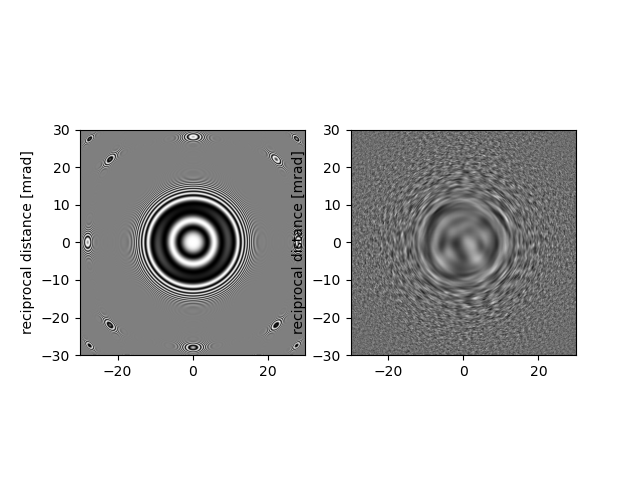

In [8]:
ronchigram = pyTEMlib.probe_tools.get_ronchigram(1024, aberrations, scale = 'mrad'  )
phase_plate =  np.cos(-aberrations['chi'])

# equivalent but more general
plt.figure()
ax1 = plt.subplot(1, 2, 1)
plt.imshow(phase_plate, extent = aberrations['ronchi_extent'], cmap='gray')
plt.ylabel(aberrations['ronchi_label'])
ax2 = plt.subplot(1, 2, 2)
plt.imshow(ronchigram, extent = aberrations['ronchi_extent'], cmap='gray')
plt.ylabel(aberrations['ronchi_label'])


## Magnification in Ronchigram
The key to understand how the ronchigram is used to analyse aberrations is to determine how  magnifcation changes within ronchigrams. 

In underfocus ($C_{10} <0$) the ronchigram shows the sample at three different places.
The center part and the outer part are easily distinguishable.
However there is a third part between the two circular features.

The two circula features are the radial (inner wheel like circle) and azimutal circle of infinite magnification.

In the outer part of the sample image, the change in magnification is obvious. However, all three parts of the sample show a change of magnification. The inner part is also a underfocused and the outer one an overfocused image.

The Hessian matrix $H$ of the aberration function $\Xi$ (2D) gives the magnifications. Lines of infinite magnifications occure where $H(\chi) = 0$. 

Below for a conventional TEM in which resolution depends only on spherical aberration $C_{30}$ and defocus $C_{10}$.

0.1


24.494897427831777 14.142135623730951


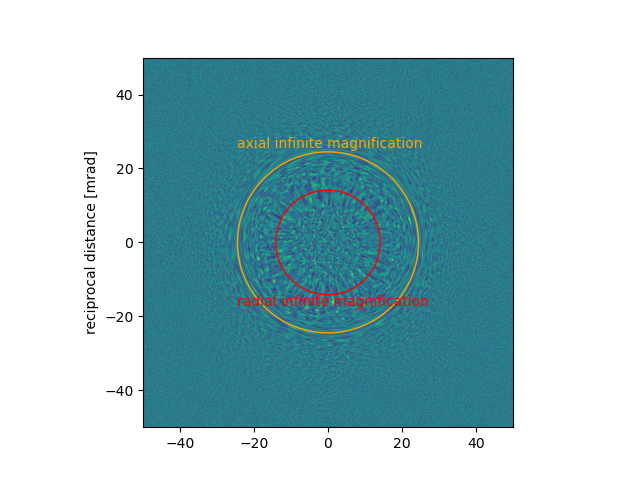

In [16]:
ab ={}
ab['C10'] =  -1200.#0.16957899999999998
ab['C12a'] =  -0.#0.16957899999999998
ab['C30'] =  2.0e6
ab['acceleration_voltage'] = 200000
ab['wavelength'] = pyTEMlib.image_tools.get_wavelength(ab['acceleration_voltage'])

ronchi_FOV = 100 #mrad
ab['FOV'] = 4/ronchi_FOV*sizeX/2 * ab['wavelength'] *1000
ab['convergence_angle'] = 100 ## let have a little bit of a view
ab['Cc']= 1e6
ronchigram = pyTEMlib.probe_tools.get_ronchigram(1024, ab, scale = 'mrad'  )

plt.figure()
plt.imshow((ronchigram), extent = ab['ronchi_extent'])
plt.ylabel(ab['ronchi_label'])
pyTEMlib.probe_tools.print_aberrations(ab)

radial_radius = np.sqrt(-ab['C10']/3/ab['C30'])*1000 #from rad to mrad
azimutal_radius = np.sqrt(-ab['C10']/ab['C30'])*1000 #from rad to mrad
print(azimutal_radius,radial_radius)
azimutal_circle = plt.Circle((0, 0), radius = azimutal_radius, fill = False, color = 'orange')
plt.gca().add_patch(azimutal_circle)
plt.text(-azimutal_radius,azimutal_radius+1,s='axial infinite magnification', color = 'orange')

radial_circle = plt.Circle((0, 0), radius = radial_radius, fill = False, color = 'red')
plt.text(-azimutal_radius,-radial_radius-3,s='radial infinite magnification', color = 'red')
plt.gca().add_patch(radial_circle);

### Infinite Magnification of Non-Rotational Aberrations

Infinite magnification in a ronchigram was defined as the zero of Jacobian ($H=0$), which is valid even for non-centro symmetric aberrations, but now we need to calculate the partial double derivatives of $\chi$, which is the Hessian matrix.

B2 [-3.583665699539742e-08, -7.368501963663006e-08]


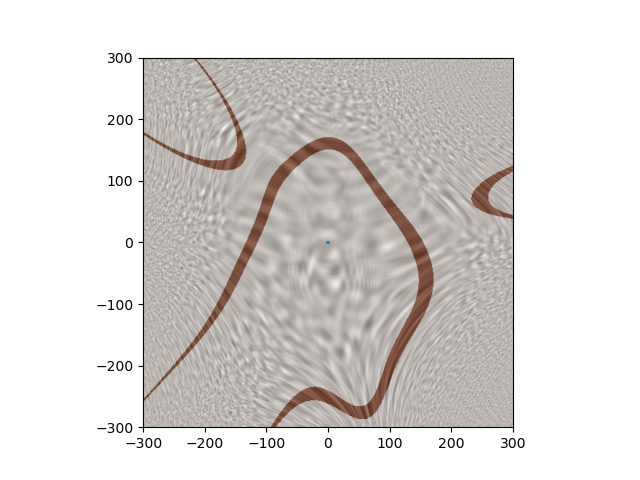

In [44]:
ab = pyTEMlib.probe_tools.get_target_aberrations("ronchi",300000)

#ab['C10'] = -57
ab['acceleration_voltage'] = 200 *1000
ab['convergence_angle'] = 30
reciprocal_FOV = ab['reciprocal_FOV'] = 300*1e-3
ab['extent'] = [-reciprocal_FOV*1000,reciprocal_FOV*1000,-reciprocal_FOV*1000,reciprocal_FOV*1000]
ab['size'] = 512
ab['wavelength'] = pyTEMlib.image_tools.get_wavelength(ab['acceleration_voltage'])
abb = {'A1': [-1.7256467648864592e-09, -4.33652950047942e-09],
  'A2': [1.1832002758281756e-07, -9.356132757317088e-08],
  'C3': [3.9123259711154475e-07, 0.0],
  'C1': [-7.160069847952156e-09, 0.0],
  'A4': [-1.2421582380458277e-06, -6.555555994007509e-07],
  'A3': [9.14858860850468e-08, 8.24581795110536e-08],
  'A5': [2.4305034548402935e-05, -4.3665588715379156e-05],
  'B2': [-3.583665699539742e-08, -7.368501963663006e-08],
  'B4': [2.7117076219729385e-07, 3.745259044319655e-06],
  'S3': [1.892912397258682e-07, -5.2074838081861786e-08],
  'C5': [-1.4203666265095235e-05, 0.0],
  'D4': [-1.0812219869916382e-07, 4.316301635786145e-06],
  'WD': [0.000120721584514962, 2.8815317878038834e-05]}

ab.update(pyTEMlib.probe_tools.ceos_carth_to_nion(abb))
ab['C10'] = -25
ab['C12a'] = 0
ab['C12b'] = 0
ab['C21a'] = 0
ab['C21b'] = 0
ab['C23a'] = 0
ab['C23b'] = 0
ronchigram, infinite_magnification = pyTEMlib.probe_tools.get_ronchigram_2(512, ab, threshold=5)

cmap = plt.cm.gray
plt.figure()
plt.imshow(ronchigram, cmap=cmap, aspect='equal', extent=ab['extent'])
plt.plot(np.arange(-256,256)/256, np.cos(ab['chi'])[256,:]/10)
plt.imshow(infinite_magnification, alpha=.5, cmap ='Oranges', extent=ab['extent'])

## The Electron Probe Shape

The shape of the electron probe is given by the absolute of the Fourier Tranform of the aberration function $\chi$multiplied by the aperture function $A_k$ 

The ideal defocus and resolution are a little different from phase contrast imaging [see Contrast Transfer function](CH3_03-CTF.ipynb).

### Aperture Size
Especially important is to determine the optimum size for the probe forming (condensor) aperture in STEM mode .
In the table below the formulas for uncorrected miscroscopes (spherical aberration limits resolution)  for TEM and STEM are summarized:

Source    |     Aperture        |     Defocus   |      Resolution
----------|----------------|--------------------|-----
Uncorrected (BF) | 1.51$(\frac{\lambda}{C_{30}})^{\frac{1}{4}}$  | -1.16$( C_{30} \lambda)^{\frac{1}{2}}$  |0.66$(C_{30}\lambda^3)^{\frac{1}{4}}$
Uncorrected (ADF)| 1.41$(\frac{\lambda}{C_{30}})^{\frac{1}{4}}$  |-$(C_{30} \lambda)^{\frac{1}{2}}$      |0.43$(C_{30}\lambda^3)^{\frac{1}{4}}$

Please note that defoci for BF STEM and *HRTEM* are the same because of the reciprocity theorem.

### Calculate Probe Shape
To calculate the probe sahpe from the aberration function, we just need to do a Foruier transform like in the beginning of this notebook. The aperture is now however illuminated by the aberrated wave.

Acceleration voltage 200.0kV  => wavelength 2.51pm
0.03
0.03


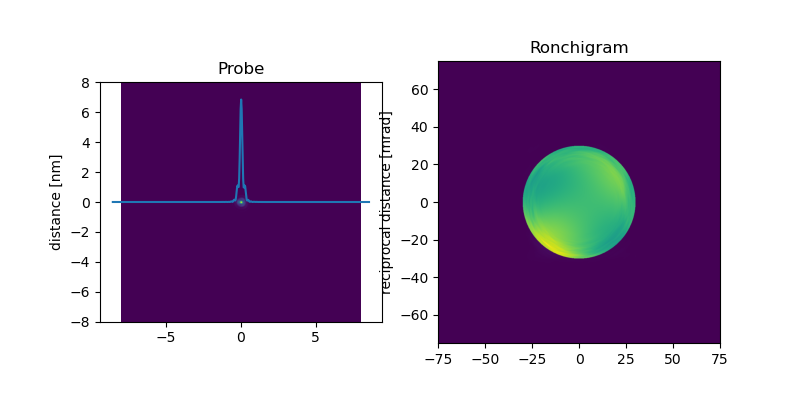

In [54]:
ab['FOV'] = 4
ab['Cc'] = 1
sizeX = sizeY =512
condensor_aperture_radius = ab['convergence_angle'] = 30
probe, A_k, chi  = pyTEMlib.probe_tools.get_probe( ab, sizeX, sizeY, verbose= True)
profile = probe[:, 256]
ronchi_FOV = 150 #mrad
ab['FOV'] = 4/ronchi_FOV*sizeX/2 * ab['wavelength'] *1000
ab['convergence_angle'] = 30 ## let have a little bit of a view
    
ronchigram = pyTEMlib.probe_tools.get_ronchigram(sizeX*2, ab, scale = 'mrad'  )

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(probe, extent = [-int(ab['FOV']/2),int(ab['FOV']/2),-int(ab['FOV']/2),int(ab['FOV']/2)])
ax[0].plot(np.linspace(-ab['FOV']/2,ab['FOV']/2,profile.shape[0]), probe[:,int(probe.shape[1]/2)]/probe.max()*ab['FOV']/2*.8)
ax[0].set_ylabel('distance [nm]')
ax[0].set_title('Probe')
ax[1].imshow(ronchigram, extent = ab['ronchi_extent'])
ax[1].set_ylabel(ab['ronchi_label'])
ax[1].set_title('Ronchigram')
pyTEMlib.probe_tools.print_aberrations(ab)

## Conclusion

The aberration function allows us to calculate
= Ronchigram
- phaseplate
- aberrated wave.

From this and the aperture (which acts here as a mask), we get the exact **probe shape**.

That is the reason we can use the Ronchigram to align the TEM.
